In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
%matplotlib inline

## Creating Data

Let's look at a cloud of data points surrounded by a circle. For this example, for each entry in the inner cloud is drawn from a $N(0,0.01)$, and each entry of the outer circle is sampled from a unit circle, with $N(0,0.01)$ noise added to each coordinate.

In [2]:
sampling_size = 100

sample = np.arange(sampling_size) * (np.pi/50)
outer_cloud = np.concatenate((np.expand_dims(np.cos(sample),1), 
                              np.expand_dims(np.sin(sample),1)), axis=1) + 0.1 * np.random.randn(sampling_size, 2)

inner_cloud = 0.1 * np.random.randn(sampling_size,2)

data = np.concatenate((outer_cloud, inner_cloud), axis=0)
colormap = np.concatenate((np.zeros(sampling_size),np.ones(sampling_size)))

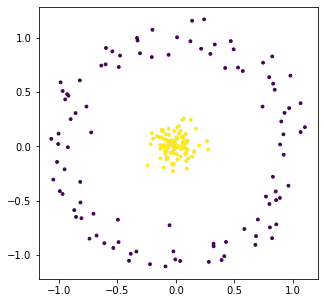

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(data[:,0], data[:,1], s=8, c=colormap)

### Some embeddings of this data

In [4]:
emb = np.empty((5, 2*sampling_size, 2))

In [5]:
emb[0] = KernelPCA(n_components=2, kernel='linear').fit_transform(data)
emb[1] = KernelPCA(n_components=2, kernel='poly').fit_transform(data)
emb[2] = KernelPCA(n_components=2, kernel='rbf').fit_transform(data)
emb[3] = KernelPCA(n_components=2, kernel='sigmoid').fit_transform(data)
emb[4] = KernelPCA(n_components=2, kernel='cosine').fit_transform(data)

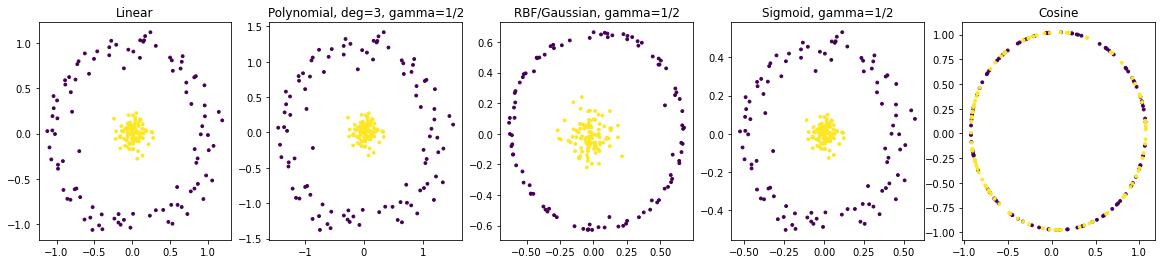

In [6]:
desc = ['Linear','Polynomial, deg=3, gamma=1/2', 'RBF/Gaussian, gamma=1/2', 'Sigmoid, gamma=1/2', 'Cosine']

fig,axes = plt.subplots(1,5, figsize=(20,4))
for i,ax in enumerate(axes.flat):
    ax.scatter(emb[i,:,0], emb[i,:,1], s=8, c=colormap)
    ax.set_title(desc[i])

### Varying Gamma for RBF (Gaussian) Kernel

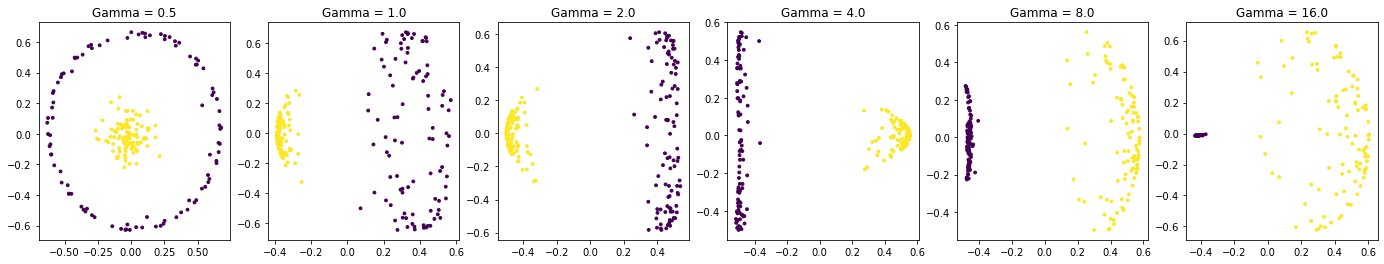

In [7]:
gamma_vals = np.asarray([0.5, 1, 2, 4, 8, 16])

emb = np.empty((gamma_vals.shape[0], 2*sampling_size, 2))

for i in range(gamma_vals.shape[0]):
    emb[i] = KernelPCA(n_components=2, kernel='rbf', gamma=gamma_vals[i]).fit_transform(data)

fig,axes = plt.subplots(1,gamma_vals.shape[0], figsize=(4*gamma_vals.shape[0],4))
for i,ax in enumerate(axes.flat):
    ax.scatter(emb[i,:,0], emb[i,:,1], s=8, c=colormap)
    ax.set_title(f"Gamma = {gamma_vals[i]}")

# Randomized KPCA

We can add randomness into Kernel PCA in two main ways:

- Using randomness to lower the dimensionality of the data matrix, similarly to RSVD
- Using randomness in the kernel function

First we attempt the second:

In [8]:
def RKPCA(data, n_components, m):
    X = np.copy(data) # n x d
    n, d = X.shape
    b = np.random.uniform(low=0, high = 2*np.pi, size=(1,m))
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=(2/784)*np.eye(d), size=m) # m x d
    Z = np.empty((n,m))
    Z = np.cos(X @ W.T + b) # n x m
    K = 1/m * Z @ Z.T
    return KernelPCA(n_components=n_components, kernel='precomputed').fit_transform(K)

In [9]:
def plot(embedding, color_labels):
    if(embedding.shape[1] == 2):
        %matplotlib inline
        plt.scatter(embedding[:,0],embedding[:,1],s=8,c=color_labels)
        plt.show()
    elif(embedding.shape[1]==3):
        %matplotlib notebook
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(embedding[:,0],embedding[:,1],embedding[:,2], s=8, c=color_labels)
        plt.show()
        %matplotlib inline
    else:
        raise ValueError

In [10]:
n, d = data.shape

m = 10          # low dimension m << n
b = np.zeros((1,m))#np.random.uniform(low=0, high = 2*np.pi, size=(1,m))

In [11]:
start = perf_counter()
W = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=m) # m x d
Z = np.cos(data @ W.T + b) # n x m
K = 1/m * Z @ Z.T
emb = KernelPCA(n_components=2, kernel='precomputed').fit_transform(K)
end = perf_counter()
rand_time = end - start

Text(0.5, 1.0, 'Random KPCA')

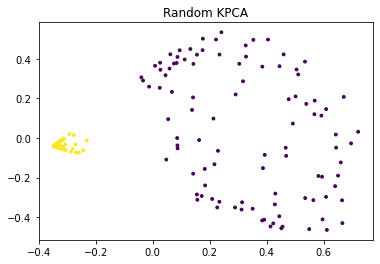

In [12]:
plt.scatter(emb[:,0],emb[:,1], s=8, c=colormap)
plt.title('Random KPCA')

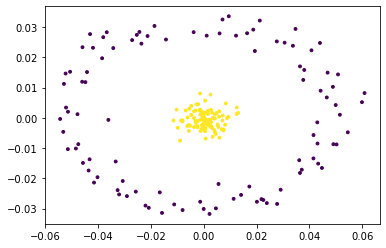

In [13]:
plot(RKPCA(data, 2, 10), colormap)

## Experiments on MNIST 

In [14]:
mnist = pd.read_csv('../datasets/mnist/train.csv')

full_X = mnist[mnist.columns[1:]].values / 255
full_y = mnist.label.values

X = full_X[:1000]
y = full_y[:1000]

In [15]:
n,d = X.shape

### KPCA with polynomial kernel

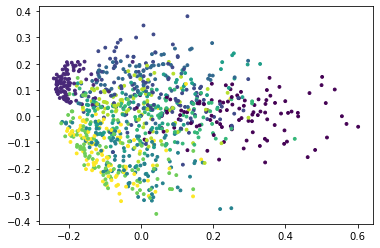

In [16]:
emb = KernelPCA(n_components=2, kernel='poly').fit_transform(X)
plt.scatter(emb[:,0],emb[:,1],s=8,c=y)

### KPCA with gaussian kernel

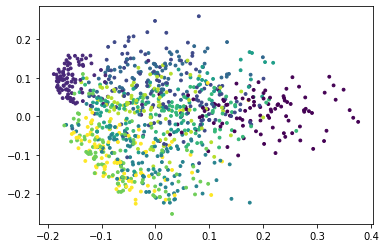

In [17]:
emb = KernelPCA(n_components=2, kernel='rbf').fit_transform(X)
plt.scatter(emb[:,0],emb[:,1],s=8,c=y)

### RKPCA emulating gaussian kernel

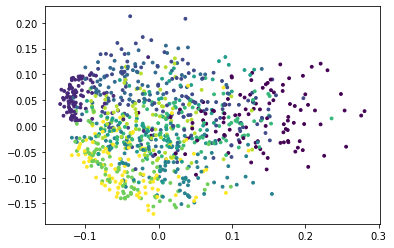

In [18]:
emb = RKPCA(X, 2, 600)
plot(emb, y)

In [19]:
#Reference
#from sklearn import manifold
#plot(manifold.TSNE(n_components=2).fit_transform(X), y)

In [20]:
#plot(manifold.TSNE(n_components=3).fit_transform(X), y)

# SVM Classification using Random Fourier Features Kernel

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [22]:
def generate_kernel(m=350, covariance=1/d):
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m))
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=2*covariance*np.eye(d), size=m) # m x d
    def ker(x, y):
        z1 = np.cos(x @ W.T + b)
        z2 = np.cos(y @ W.T + b)
        return z1 @ z2.T / m
    return ker

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [24]:
start = perf_counter()
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
det_score = svm.score(X_test, y_test)
end = perf_counter()
det_time = end - start


iterations = 100
scores = np.empty(iterations)
times = np.empty(iterations)

for i in tqdm(range(iterations)):
    start = perf_counter()
    random_svm = SVC(kernel=generate_kernel())
    random_svm.fit(X_train, y_train)
    end = perf_counter()
    times[i] = end - start
    scores[i] = random_svm.score(X_test, y_test)

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


In [25]:
print(f'Gaussian kernel: Accuracy: {det_score}, time: {det_time}')
print(f'Random kernel: Mean accuracy: {np.mean(scores)}, stdev: {np.std(scores)}, mean time: {np.mean(times)}')
print(f'Acc. stats: Q0: {np.min(scores)}, Q1: {np.quantile(scores, 0.25)}, Q2: {np.median(scores)}, Q3: {np.quantile(scores,0.75)}, Q4: {np.max(scores)}')
# TODO is this first section particularly informative? we already have the varying versions below, so is it a bit redundant?
# maybe i'm missing something that sets it apart.

Gaussian kernel: Accuracy: 0.855, time: 2.4005461000006107
Random kernel: Mean accuracy: 0.7408999999999999, stdev: 0.024097510244836518, mean time: 0.4208462989999498
Acc. stats: Q0: 0.69, Q1: 0.725, Q2: 0.74, Q3: 0.76, Q4: 0.8


## Accuracy as a function of gamma

In [26]:
# TODO is this gamma or covariance? it seemed it was being used for both deterministic and randomized
domain = (1/784) * np.asarray([.125,.25,.5,1,2,4,8,16,32,64,128])

### deterministic rbf kernel

100%|██████████| 11/11 [00:31<00:00,  2.88s/it]


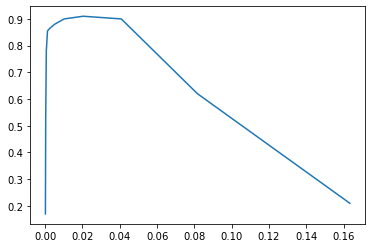

In [30]:
scores = []

for val in tqdm(domain):
    svm = SVC(gamma=val)
    svm.fit(X_train, y_train)
    scores.append(svm.score(X_test, y_test))
    
plt.plot(domain, scores)

### random rbf kernel

In [31]:
iterations = 10
scores = np.empty((domain.shape[0], iterations))
    
for i,val in tqdm(enumerate(domain)):
    for j in range(iterations):
        random_svm = SVC(kernel=generate_kernel(covariance=val))
        random_svm.fit(X_train, y_train)
        scores[i,j] = random_svm.score(X_test, y_test)


# TODO is it possible to get rid of the for loop here?
stat = np.empty((7, domain.shape[0]))
for i in range(domain.shape[0]):
    stat[0,i] = np.min(scores[i])
    stat[1,i] = np.quantile(scores[i], 0.25)
    stat[2,i] = np.median(scores[i])
    stat[3,i] = np.quantile(scores[i], 0.75)
    stat[4,i] = np.max(scores[i])
    stat[5,i] = np.mean(scores[i])
    stat[6,i] = np.std(scores[i])

11it [00:52,  4.77s/it]


Text(0.5, 1.0, "Randomized Kernel SVM accuracy 'continuous boxplot'")

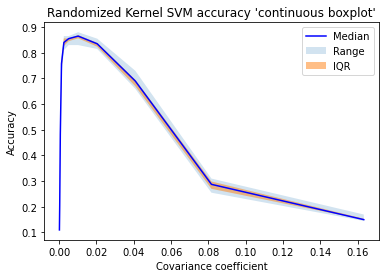

In [32]:
plt.plot(domain, stat[2], c='b', label='Median')
plt.fill_between(domain, stat[4], stat[0], alpha=0.2, label='Range', lw=1)
plt.fill_between(domain, stat[1], stat[3], alpha=0.5, label='IQR', lw=1)
plt.xlabel('Covariance coefficient')
plt.ylabel('Accuracy')
#plt.set_yscale('log')
plt.legend(loc='upper right')
plt.title('Randomized Kernel SVM accuracy \'continuous boxplot\'')

### accuracy as a function of m (low-dim projection dim)

In [38]:
m_domain = np.asarray([10, 50, 100, 200, 400, 750])
np.arange(start=100, stop=800, step=100)

array([100, 200, 300, 400, 500, 600, 700])

In [39]:
iterations = 10
scores = np.empty((m_domain.shape[0],iterations))
    
for i,val in tqdm(enumerate(m_domain)):
    for j in range(iterations):
        random_svm = SVC(kernel=generate_kernel(m=val))
        random_svm.fit(X_train, y_train)
        scores[i,j] = random_svm.score(X_test, y_test)
        

# TODO is it possible to get rid of the for loop here?
stat = np.empty((7, m_domain.shape[0]))
for i in range(m_domain.shape[0]):
    stat[0][i] = np.min(scores[i])
    stat[1][i] = np.quantile(scores[i], 0.25)
    stat[2][i] = np.median(scores[i])
    stat[3][i] = np.quantile(scores[i], 0.75)
    stat[4][i] = np.max(scores[i])
    stat[5][i] = np.mean(scores[i])
    stat[6][i] = np.std(scores[i])

6it [00:24,  4.12s/it]


Text(0.5, 1.0, 'Randomized Kernel SVM accuracy as a function of m')

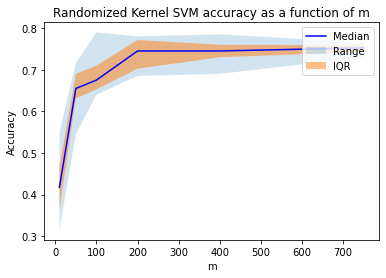

In [40]:
plt.plot(m_domain, stat[2], c='b', label='Median')
plt.fill_between(m_domain, stat[4], stat[0], alpha=0.2, label='Range', lw=1)
plt.fill_between(m_domain, stat[1], stat[3], alpha=0.5, label='IQR', lw=1)
plt.xlabel('m')
plt.ylabel('Accuracy')
#plt.set_yscale('log')
plt.legend(loc='upper right')
plt.title('Randomized Kernel SVM accuracy as a function of m')

## Plotting code for KPCA demonstration with slider widget

Often needs to be run twice to actually work, not sure why

In [41]:
# # TEST cell for plotting
# %matplotlib notebook
# from ipywidgets import *

# plt.ion()

# emb = KernelPCA(n_components=2, kernel='rbf', gamma=0.5).fit_transform(data)
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# outer, = ax.plot(emb.T[0][:100],emb.T[1][:100],marker='o', linestyle='', color='y')
# inner, = ax.plot(emb.T[0][100:200],emb.T[1][100:200],marker='o', linestyle='', color='purple')

# def update(gamma):
#     emb = KernelPCA(n_components=2, kernel='rbf', gamma=gamma).fit_transform(data)
#     outer.set_xdata(emb.T[0][:100])
#     outer.set_ydata(emb.T[1][:100])
#     inner.set_xdata(emb.T[0][100:200])
#     inner.set_ydata(emb.T[1][100:200])
    
#     fig.canvas.draw_idle()

# interact(update, gamma = widgets.FloatSlider(value=0.5,min=0,max=30,step=0.01))

# %matplotlib inline

### Code used to create GIF of RKPCA

In [42]:
# domain = np.square(np.arange(0.02,5,0.02))

# for i,value in enumerate(domain):
#     emb = KernelPCA(n_components=2, kernel='rbf', gamma=value).fit_transform(data)
#     plt.scatter(emb.T[0],emb.T[1], s=8, c=colormap)
#     plt.ylim(-0.7, 0.7)
#     plt.xlim(-0.7, 0.7)
#     plt.savefig('temp/img'+str(i).zfill(4)+'.png')
#     plt.clf()